# COVID-19 Prediction Analysis

In [1]:
# Suppress warning messages
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Import general dependencies
import os 
import pandas as pd
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import datetime

In [3]:
#Import connection dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import psycopg2

In [4]:
# Import machine learning dependencies 
import sklearn as skl
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
# from imblearn.metrics import classificationn_report_imbalanced 
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
# import keras_tuner as kt

### Data Source

**Our World in Data COVID-19 Dataset Citation**
Hannah Ritchie, Edouard Mathieu, Lucas Rodés-Guirao, Cameron Appel, Charlie Giattino, Esteban Ortiz-Ospina, Joe Hasell, Bobbie Macdonald, Diana Beltekian and Max Roser (2020) - "Coronavirus Pandemic (COVID-19)". Published online at OurWorldInData.org. Retrieved from: [Our World In Data / Coronavirus](https://ourworldindata.org/coronavirus)

In [ ]:
# # Create connection to SQL database
# conn = psycopg2.connect(
#     host="finalproject.cjgqtjwgyywe.us-east-2.rds.amazonaws.com",
#     database="postgres",
#     user="postgres",
#     password="FinalProject1")

In [ ]:
# # Read the OneWorldInData COVID-19 database into a DataFrame
# df = pd.read_sql("SELECT * from all_countries_data", conn)
# print(df.shape)
# df.head()

In [ ]:
# # Set the id_row column as index and reorder records by id.
# df = df.set_index('id_row').sort_values(by='id_row')
# print(df.shape)
# df.head()

In [ ]:
# # Check non-null counts and data types.
# df.info()

In [ ]:
# # Count the records in the COVID-19 DataFrame.
# records = df["location"].count()
# print(f"There are {records} location-specific records in the OWID COVID-19 dataset as of July 5th, 2022.")

In [ ]:
# # Check the earliest and latest date in the dataset. 
# df["date"].sort_values()

The OWID COVID-19 data entry started on January 1st, 2020 and has been daily updated till July 4th, 2022 when we pulled the dataset from the [OWID/COVID-19-data GitHub Repository](https://github.com/owid/covid-19-data/tree/master/public/data).

In [5]:
# Load the cases prediction cleaned data file.
cases_file_path = Path('./Resources/cases_pred.csv')
df = pd.read_csv(cases_file_path)
print(df.shape)
df.head()

(112069, 30)


,id_row,location,covid_days,total_cases,new_cases,new_cases_smoothed,new_cases_smoothed_per_million,reproduction_rate,total_vaccinations,people_fully_vaccinated,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
0,34,Afghanistan,88,114.0,8.0,11.429,0.287,1.52,0.0,0.0,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
1,35,Afghanistan,89,114.0,0.0,10.571,0.265,1.52,0.0,0.0,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
2,36,Afghanistan,90,166.0,52.0,17.714,0.445,1.53,0.0,0.0,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
3,37,Afghanistan,91,192.0,26.0,16.857,0.423,1.52,0.0,0.0,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
4,38,Afghanistan,92,235.0,43.0,22.143,0.556,1.52,0.0,0.0,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [6]:
# Set the id_row column as index and reorder records by id.
df = df.set_index('id_row').sort_values(by='id_row')
print(df.shape)
df.head()

(112069, 29)


,location,covid_days,total_cases,new_cases,new_cases_smoothed,new_cases_smoothed_per_million,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,,,,,,,,,
34,Afghanistan,88,114.0,8.0,11.429,0.287,1.52,0.0,0.0,67.59,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
35,Afghanistan,89,114.0,0.0,10.571,0.265,1.52,0.0,0.0,67.59,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
36,Afghanistan,90,166.0,52.0,17.714,0.445,1.53,0.0,0.0,67.59,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
37,Afghanistan,91,192.0,26.0,16.857,0.423,1.52,0.0,0.0,67.59,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
38,Afghanistan,92,235.0,43.0,22.143,0.556,1.52,0.0,0.0,67.59,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112069 entries, 34 to 198747
Data columns (total 29 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   location                                112069 non-null  object 
 1   covid_days                              112069 non-null  int64  
 2   total_cases                             112069 non-null  float64
 3   new_cases                               112069 non-null  float64
 4   new_cases_smoothed                      111964 non-null  float64
 5   new_cases_smoothed_per_million          111964 non-null  float64
 6   reproduction_rate                       112069 non-null  float64
 7   total_vaccinations                      112069 non-null  float64
 8   people_fully_vaccinated                 112069 non-null  float64
 9   stringency_index                        112069 non-null  float64
 10  population                              112

To predict the daily number of new COVID-19 cases, we will focus on processing the following columns and creating new features off of these: (**total_cases, new_cases, total_cases_per_100K, new_cases_per_100K, reproduction_rate, total_vaccinations, people_fully_vaccinated, total_vaccinations_per_100K, people_fully_vaccinated_per_100K, stringency_index, population, population_density, median_age, aged_65_older, gdp_per_capita, cardiovasc_death_rate, diabetes_prevalence, life_expectancy, human_development_index, daily_vaccinations_per_100K, daily_people_fully_vaccinated_per_100K**). 

We presume that vaccination  has played an integral role in the COVID-19 pandemic trajectory, and its influence may be observed over both COVID-19 cases and deaths.

We will not be using smoothed numbers for now, but we will leave these columns in a separate dataframe that contains averages in case we were able to revisit the code and run a more elaborate feature engineering including calculating rolling averages of new vaccines and people_fully_vaccinated. At that point, we could use the cleaned dataframe and handle the missing values of the smoothed columns: (**new_cases_smoothed, new_cases_smoothed_per_million, new_vaccinations_smoothed, new_vaccinations_smoothed_per_million**).

The reason we will leave **female_smokers** and **male_smokers** out of the new_cases prediction features for now is the substantial number of missing values. 
*Reconsider inclusing **female_smokers**, and **male_smokers** in the features for new_cases prediction model if the model needs feature enhancement. The logic behind it is that smokers might be more symptomatic when infected with COVID-19, hence they seek testing and that would increase the documented number of the cases. Same concept applies to the populations' rates of cardiovascular_death and diabetes_prevalence. 

In [8]:
# Drop unnecessary columns.
cols_drop = ['new_cases_smoothed', 'new_cases_smoothed_per_million',
            'female_smokers', 'male_smokers']
focused_general_df = df.drop(columns=cols_drop, axis=1)
print(focused_general_df.shape) 
focused_general_df.info()

(112069, 25)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112069 entries, 34 to 198747
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   location                                112069 non-null  object 
 1   covid_days                              112069 non-null  int64  
 2   total_cases                             112069 non-null  float64
 3   new_cases                               112069 non-null  float64
 4   reproduction_rate                       112069 non-null  float64
 5   total_vaccinations                      112069 non-null  float64
 6   people_fully_vaccinated                 112069 non-null  float64
 7   stringency_index                        112069 non-null  float64
 8   population                              112069 non-null  float64
 9   population_density                      112069 non-null  float64
 10  median_age                    

In [9]:
# Check missing values in the focused dataframe
focused_general_df.isnull().sum()

location                                   0
covid_days                                 0
total_cases                                0
new_cases                                  0
reproduction_rate                          0
total_vaccinations                         0
people_fully_vaccinated                    0
stringency_index                           0
population                                 0
population_density                         0
median_age                                 0
aged_65_older                              0
gdp_per_capita                             0
cardiovasc_death_rate                      0
diabetes_prevalence                        0
life_expectancy                            0
human_development_index                    0
daily_vaccinations                         0
daily_people_fully_vaccinated              0
total_cases_per_100K                       0
new_cases_per_100K                        78
total_vaccinations_per_100K                0
people_ful

In [10]:
# Drop missing values from new_cases_per_100K
check_df = focused_general_df[['new_cases', 'population', 'new_cases_per_100K']]
see_nulls = check_df.loc[check_df.new_cases_per_100K.isnull()]
see_nulls.head(10)

,new_cases,population,new_cases_per_100K
id_row,,,
679,0.0,3.983543e+07,NaN
6400,0.0,9.872800e+04,NaN
11096,0.0,2.578822e+07,NaN
11112,0.0,2.578822e+07,NaN
13572,0.0,3.969140e+05,NaN
18998,0.0,1.245103e+07,NaN
24929,0.0,2.139934e+08,NaN
25383,0.0,2.139934e+08,NaN
27143,0.0,4.415320e+05,NaN


In [11]:
# Replace the missing values in the normalized new_cases_per_100K column with a rate calculation.
focused_general_df.new_cases_per_100K.fillna(focused_general_df.new_cases / focused_general_df.population * 100000, inplace=True)
focused_general_df.isnull().sum()

location                                  0
covid_days                                0
total_cases                               0
new_cases                                 0
reproduction_rate                         0
total_vaccinations                        0
people_fully_vaccinated                   0
stringency_index                          0
population                                0
population_density                        0
median_age                                0
aged_65_older                             0
gdp_per_capita                            0
cardiovasc_death_rate                     0
diabetes_prevalence                       0
life_expectancy                           0
human_development_index                   0
daily_vaccinations                        0
daily_people_fully_vaccinated             0
total_cases_per_100K                      0
new_cases_per_100K                        0
total_vaccinations_per_100K               0
people_fully_vaccinated_per_100K

## Data Exploration

In [12]:
# Count the number of locations in the focused_general_df
print(f"There are {focused_general_df.location.nunique()} locations in the cleaned dataframe.")

There are 177 locations in the cleaned dataframe.


In [13]:
# Check the date range. 
focused_general_df.covid_days.sort_values()

id_row
36732      22
36733      23
36734      24
36735      25
36736      26
         ... 
94986     817
94573     817
6723      817
99223     817
198747    817
Name: covid_days, Length: 112069, dtype: int64

The cleaned dataframe contained location_specific COVID-19 entries starting at day 22nd of the pandemic, and up to day 817th of the pandemic. 

In [14]:
# Check the count of records for each location
locations_records = focused_general_df.location.value_counts()
locations_records

South Korea        767
Italy              764
Singapore          758
France             758
Germany            757
                  ... 
Kiribati            55
Solomon Islands     51
Tonga               39
Vanuatu             18
Samoa                6
Name: location, Length: 177, dtype: int64

<AxesSubplot:ylabel='Density'>

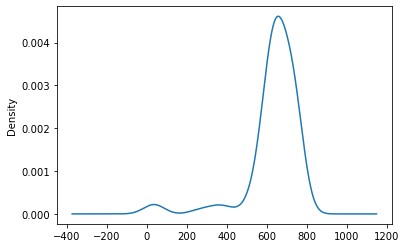

In [15]:
# Visualize locations' records.
locations_records.plot.density()

In [16]:
# Check the population range in the cleaned dataframe.
print(f"Population min: {focused_general_df.population.min()}")
print(f"Population max: {focused_general_df.population.max()}")

Population min: 98728.0
Population max: 1444216102.0


### Population Splitting

To facilitate the machine learning model application, we will split the analysis into three phases:

- Phase 1: apply only on countries with population above 1 million.
- Phase 2: apply on locations with population above 500K ( 'above 1 mill' + '500K-1mill').
- Phase 3: apply on all locations with 2-year worth of records

Create three population-based DataFrame:

- low_pop_df: Population less than 500K.
- small_countries_df: Population between 500K - 1 mill.
- mill_countries_df: Population more than 1 mill.

#### Population < 500K

In [17]:
# Create low-population DataFrame 
cases_low_pop_df = focused_general_df[focused_general_df["population"] < 500000]
print(cases_low_pop_df.shape)
cases_low_pop_df.head()

(5688, 25)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,,,,,,,,,
6177,Antigua and Barbuda,271,101.0,0.0,0.44,0.0,0.0,0.0,98728.0,231.845,...,77.02,0.778,0.0,0.0,102.3013,0.0000,0.0,0.0,0.0,0.0
6178,Antigua and Barbuda,272,101.0,0.0,0.43,0.0,0.0,0.0,98728.0,231.845,...,77.02,0.778,0.0,0.0,102.3013,0.0000,0.0,0.0,0.0,0.0
6179,Antigua and Barbuda,273,101.0,0.0,0.41,0.0,0.0,0.0,98728.0,231.845,...,77.02,0.778,0.0,0.0,102.3013,0.0000,0.0,0.0,0.0,0.0
6180,Antigua and Barbuda,274,101.0,0.0,0.40,0.0,0.0,0.0,98728.0,231.845,...,77.02,0.778,0.0,0.0,102.3013,0.0000,0.0,0.0,0.0,0.0
6181,Antigua and Barbuda,275,106.0,5.0,0.40,0.0,0.0,0.0,98728.0,231.845,...,77.02,0.778,0.0,0.0,107.3657,5.0644,0.0,0.0,0.0,0.0


In [18]:
# Check the names and count of locations with low population.
cases_low_pop_locations = cases_low_pop_df["location"].unique()
print(f" There are {len(cases_low_pop_locations)} locations with population less than 500K.")
cases_low_pop_locations

 There are 15 locations with population less than 500K.


array(['Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Brunei',
       'Grenada', 'Iceland', 'Kiribati', 'Saint Lucia',
       'Saint Vincent and the Grenadines', 'Samoa',
       'Sao Tome and Principe', 'Seychelles', 'Tonga', 'Vanuatu'],
      dtype=object)

In [19]:
# Check the records counts of location with low population
cases_low_pop_records = cases_low_pop_df.location.value_counts()
cases_low_pop_records

Brunei                              630
Sao Tome and Principe               630
Barbados                            603
Bahamas                             588
Iceland                             587
Seychelles                          523
Belize                              491
Antigua and Barbuda                 415
Saint Lucia                         388
Saint Vincent and the Grenadines    367
Grenada                             348
Kiribati                             55
Tonga                                39
Vanuatu                              18
Samoa                                 6
Name: location, dtype: int64

#### Population 500K - 1 mill

In [20]:
# Create small population DataFrame
cases_small_countries_df = focused_general_df[focused_general_df["population"].between(500000, 1000000, inclusive='left')]
print(cases_small_countries_df.shape)
cases_small_countries_df.head()

(6525, 25)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,,,,,,,,,
20760,Bhutan,212,101.0,0.0,0.51,0.0,0.0,62.96,779900.0,21.188,...,71.78,0.654,0.0,0.0,12.9504,0.0000,0.0,0.0,0.0,0.0
20761,Bhutan,213,102.0,1.0,0.49,0.0,0.0,62.96,779900.0,21.188,...,71.78,0.654,0.0,0.0,13.0786,0.1282,0.0,0.0,0.0,0.0
20762,Bhutan,214,102.0,0.0,0.48,0.0,0.0,62.96,779900.0,21.188,...,71.78,0.654,0.0,0.0,13.0786,0.0000,0.0,0.0,0.0,0.0
20763,Bhutan,215,103.0,1.0,0.48,0.0,0.0,62.96,779900.0,21.188,...,71.78,0.654,0.0,0.0,13.2068,0.1282,0.0,0.0,0.0,0.0
20764,Bhutan,216,105.0,2.0,0.48,0.0,0.0,62.96,779900.0,21.188,...,71.78,0.654,0.0,0.0,13.4633,0.2564,0.0,0.0,0.0,0.0


In [21]:
# Check the names and count countries with small population value (500K - 1 mill).
cases_small_pop_locations = cases_small_countries_df["location"].unique()
print(f" There are {len(cases_small_pop_locations)} locations with population between 500K and 1 million.")
cases_small_pop_locations

 There are 12 locations with population between 500K and 1 million.


array(['Bhutan', 'Cape Verde', 'Comoros', 'Cyprus', 'Fiji', 'Guyana',
       'Luxembourg', 'Maldives', 'Malta', 'Montenegro', 'Solomon Islands',
       'Suriname'], dtype=object)

In [22]:
# Check the records count of small countries to be 730+ for cases_pred_df.
cases_small_pop_records = cases_small_countries_df.location.value_counts()
cases_small_pop_records

Malta              732
Luxembourg         703
Montenegro         689
Maldives           635
Comoros            616
Cape Verde         607
Cyprus             587
Suriname           566
Guyana             553
Bhutan             536
Fiji               250
Solomon Islands     51
Name: location, dtype: int64

#### Population 1 million and above

In [23]:
# Create 1 million and above population DataFrame for cases_pred_df.
cases_mill_countries_df = focused_general_df[(focused_general_df["population"] >= 1000000)]
print(cases_mill_countries_df.shape)
cases_mill_countries_df.head()

(99856, 25)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,,,,,,,,,
34,Afghanistan,88,114.0,8.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
35,Afghanistan,89,114.0,0.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
36,Afghanistan,90,166.0,52.0,1.53,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
37,Afghanistan,91,192.0,26.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
38,Afghanistan,92,235.0,43.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [24]:
# Check the names and count of countries with population more than 1 mill.
cases_mill_countries_list = cases_mill_countries_df["location"].unique()
print(f" There are {len(cases_mill_countries_list)} countries with population of 1 million and above.")
cases_mill_countries_list

 There are 150 countries with population of 1 million and above.


array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Benin', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Czechia',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany',
       'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Haiti',
       'Honduras', 'Hungary', 'India', 'Indonesia', 'Iran', 'Iraq',
       'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan',
       'Kazakhstan', 'Kenya', 'Kuwait', 'Kyrgyz

In [25]:
# Check the records count of 1 million+ countries.
cases_mill_pop_records = cases_mill_countries_df.location.value_counts()
cases_mill_pop_records

South Korea         767
Italy               764
Singapore           758
France              758
Germany             757
                   ... 
Botswana            549
Papua New Guinea    543
Angola              543
Timor               327
Laos                279
Name: location, Length: 150, dtype: int64

In [26]:
# Get the locations with less than 730 records.
low_rec_locations= {}
for key, value in cases_mill_pop_records.items():
    if value < 730:
        location = {key: value}
        low_rec_locations.update(location)
print(f"There are {len(low_rec_locations)} locations with less than 730 daily records.")
print(f"These locations are: ")
low_rec_locations

There are 117 locations with less than 730 daily records.
These locations are: 


{'Lithuania': 729,
 'Thailand': 727,
 'Indonesia': 726,
 'Greece': 726,
 'Ukraine': 725,
 'Bulgaria': 723,
 'Lebanon': 722,
 'Saudi Arabia': 722,
 'Bolivia': 719,
 'Cambodia': 713,
 'Russia': 709,
 'Dominican Republic': 709,
 'Kyrgyzstan': 707,
 'Azerbaijan': 704,
 'Bosnia and Herzegovina': 701,
 'Qatar': 701,
 'Sri Lanka': 699,
 'Trinidad and Tobago': 698,
 'Algeria': 698,
 'Kazakhstan': 695,
 'Burkina Faso': 693,
 'Venezuela': 691,
 'Guatemala': 687,
 'Tunisia': 687,
 'Tanzania': 684,
 'Kuwait': 683,
 'Ghana': 682,
 'Vietnam': 681,
 'Djibouti': 681,
 'United Arab Emirates': 680,
 'Niger': 679,
 'Ethiopia': 677,
 'Palestine': 677,
 'Madagascar': 677,
 'Poland': 675,
 'Mauritius': 670,
 'Liberia': 670,
 'Mexico': 664,
 'Congo': 664,
 "Cote d'Ivoire": 664,
 'Sudan': 664,
 'Hungary': 663,
 'Rwanda': 663,
 'Senegal': 663,
 'Afghanistan': 662,
 'Colombia': 662,
 'Paraguay': 660,
 'Croatia': 659,
 'Armenia': 658,
 'Jordan': 658,
 'Moldova': 657,
 'Uzbekistan': 657,
 'Iran': 657,
 'Kenya': 6

##### PHASE 3 DATAFRAME: apply on all locations with 2-year worth of records

We will keep locations with two-year worth of records each to establish a good amount historical data points for prediction models. Two_year worth of daily records = 730 records

In [27]:
# Check the records count of all locations.
cases_all_records = focused_general_df.location.value_counts()
cases_all_records

South Korea        767
Italy              764
Singapore          758
France             758
Germany            757
                  ... 
Kiribati            55
Solomon Islands     51
Tonga               39
Vanuatu             18
Samoa                6
Name: location, Length: 177, dtype: int64

In [28]:
# Get the locations with less than 730 records.
low_rec_all_locations= {}
for key, value in cases_all_records.items():
    if value < 730:
        location = {key: value}
        low_rec_all_locations.update(location)
print(f"There are {len(low_rec_all_locations)} locations with less than 730 daily records.")
print(f"These locations are: ")
low_rec_all_locations

There are 143 locations with less than 730 daily records.
These locations are: 


{'Lithuania': 729,
 'Thailand': 727,
 'Indonesia': 726,
 'Greece': 726,
 'Ukraine': 725,
 'Bulgaria': 723,
 'Lebanon': 722,
 'Saudi Arabia': 722,
 'Bolivia': 719,
 'Cambodia': 713,
 'Dominican Republic': 709,
 'Russia': 709,
 'Kyrgyzstan': 707,
 'Azerbaijan': 704,
 'Luxembourg': 703,
 'Qatar': 701,
 'Bosnia and Herzegovina': 701,
 'Sri Lanka': 699,
 'Algeria': 698,
 'Trinidad and Tobago': 698,
 'Kazakhstan': 695,
 'Burkina Faso': 693,
 'Venezuela': 691,
 'Montenegro': 689,
 'Guatemala': 687,
 'Tunisia': 687,
 'Tanzania': 684,
 'Kuwait': 683,
 'Ghana': 682,
 'Vietnam': 681,
 'Djibouti': 681,
 'United Arab Emirates': 680,
 'Niger': 679,
 'Ethiopia': 677,
 'Madagascar': 677,
 'Palestine': 677,
 'Poland': 675,
 'Liberia': 670,
 'Mauritius': 670,
 'Congo': 664,
 'Mexico': 664,
 "Cote d'Ivoire": 664,
 'Sudan': 664,
 'Hungary': 663,
 'Rwanda': 663,
 'Senegal': 663,
 'Afghanistan': 662,
 'Colombia': 662,
 'Paraguay': 660,
 'Croatia': 659,
 'Armenia': 658,
 'Jordan': 658,
 'Iran': 657,
 'Uzbeki

In [29]:
# Bucket all locations with less than 2yrs of records into "other" bin.
all_locations_2yr_df = focused_general_df.copy()
for area in low_rec_all_locations:
    all_locations_2yr_df.location = all_locations_2yr_df.location.replace(area, "other")
# Check that binning was successful
all_locations_2yr_df.location.value_counts()

other             86723
South Korea         767
Italy               764
Singapore           758
France              758
Germany             757
United Kingdom      756
China               755
United States       754
Belgium             752
Japan               752
Switzerland         751
Canada              750
Norway              750
Malaysia            749
Israel              745
Denmark             745
Czechia             745
Australia           743
Estonia             743
Romania             743
Peru                741
Brazil              740
Slovenia            740
Ireland             740
Bahrain             739
Argentina           738
Uruguay             738
Turkey              736
Chile               735
New Zealand         734
Latvia              733
India               733
Malta               732
Ecuador             730
Name: location, dtype: int64

In [31]:
# Create a new DataFrame of locations with at least 2yr of records.
all_locations_2yr_df = all_locations_2yr_df[all_locations_2yr_df.location != 'other']
print(all_locations_2yr_df.shape)
all_locations_2yr_df.head()

(25346, 25)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,,,,,,,,,
6902,Argentina,80,158.0,30.0,2.34,0.0,0.0,88.89,45605823.0,16.177,...,76.67,0.845,0.0,0.0,0.3464,0.0658,0.0,0.0,0.0,0.0
6903,Argentina,81,266.0,108.0,2.35,0.0,0.0,88.89,45605823.0,16.177,...,76.67,0.845,0.0,0.0,0.5833,0.2368,0.0,0.0,0.0,0.0
6904,Argentina,82,301.0,35.0,2.23,0.0,0.0,100.00,45605823.0,16.177,...,76.67,0.845,0.0,0.0,0.6600,0.0767,0.0,0.0,0.0,0.0
6905,Argentina,83,387.0,86.0,2.11,0.0,0.0,100.00,45605823.0,16.177,...,76.67,0.845,0.0,0.0,0.8486,0.1886,0.0,0.0,0.0,0.0
6906,Argentina,84,387.0,0.0,2.03,0.0,0.0,100.00,45605823.0,16.177,...,76.67,0.845,0.0,0.0,0.8486,0.0000,0.0,0.0,0.0,0.0


In [32]:
# Check successful filtering based on number of records for each location.
all_locations_2yr_df.location.value_counts()

South Korea       767
Italy             764
Singapore         758
France            758
Germany           757
United Kingdom    756
China             755
United States     754
Japan             752
Belgium           752
Switzerland       751
Canada            750
Norway            750
Malaysia          749
Czechia           745
Denmark           745
Israel            745
Estonia           743
Romania           743
Australia         743
Peru              741
Slovenia          740
Ireland           740
Brazil            740
Bahrain           739
Argentina         738
Uruguay           738
Turkey            736
Chile             735
New Zealand       734
Latvia            733
India             733
Malta             732
Ecuador           730
Name: location, dtype: int64

##### PHASE 2 DATAFRAME: apply on locations with population above 500K ( 'above 1 mill' + '500K-1mill')

Locations with population above 500K ( 'above 1 mill' + '500K-1mill').

In [33]:
# Create a DataFrame with population >= 500K.
above_5_countries_df = focused_general_df.copy()
above_5_countries_df = above_5_countries_df[(above_5_countries_df.population >= 500000)]
print(above_5_countries_df.shape)
above_5_countries_df.head()

(106381, 25)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,,,,,,,,,
34,Afghanistan,88,114.0,8.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
35,Afghanistan,89,114.0,0.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
36,Afghanistan,90,166.0,52.0,1.53,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
37,Afghanistan,91,192.0,26.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
38,Afghanistan,92,235.0,43.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [34]:
# Count of countries
above_5_countries_df.location.nunique()

162

##### PHASE 1 DATAFRAME:  apply only on countries with population of 1 million and above.

In [35]:
cases_mill_countries_df.shape

(99856, 25)

In [36]:
cases_mill_countries_df.location.nunique()

150

In [37]:
cases_mill_countries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99856 entries, 34 to 198747
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   location                                99856 non-null  object 
 1   covid_days                              99856 non-null  int64  
 2   total_cases                             99856 non-null  float64
 3   new_cases                               99856 non-null  float64
 4   reproduction_rate                       99856 non-null  float64
 5   total_vaccinations                      99856 non-null  float64
 6   people_fully_vaccinated                 99856 non-null  float64
 7   stringency_index                        99856 non-null  float64
 8   population                              99856 non-null  float64
 9   population_density                      99856 non-null  float64
 10  median_age                              99856 non-null  

In [38]:
# Export the cases prediction DataFrame of countries with 1 mill+ to a csv file.
cases_1mill_output_file = Path("./Resources/cases_1mill_pred.csv")
cases_mill_countries_df.to_csv(cases_1mill_output_file, index=True)

## Data Preprocessing

Because both Scikit-Learn's RandomForestRegression class and TensorFlow's Sequential class require preprocessing, we can perform our preprocessing steps on all of the data—no need to keep track of separate scaled and unscaled data.

The only categorical data we have is the location, which we will separate from the rest of the features. 

In [39]:
# Create a new DataFrame that holds only the cryptocurrencies names.
location_name_df = cases_mill_countries_df[["location"]].copy(deep=True)
location_name_df.head(10)

,location
id_row,
34,Afghanistan
35,Afghanistan
36,Afghanistan
37,Afghanistan
38,Afghanistan
39,Afghanistan
40,Afghanistan
41,Afghanistan
42,Afghanistan


In [40]:
location_name_df.location.value_counts()

South Korea         767
Italy               764
Singapore           758
France              758
Germany             757
                   ... 
Botswana            549
Papua New Guinea    543
Angola              543
Timor               327
Laos                279
Name: location, Length: 150, dtype: int64

In [41]:
# Create a new DataFrame with the engineered columns for the model. 
cols_drop_phase1 = ['location', 'total_cases', 'new_cases', 'total_vaccinations', 
                   'people_fully_vaccinated', 'daily_vaccinations', 'daily_people_fully_vaccinated']
phase1_cases_df = cases_mill_countries_df.drop(columns=cols_drop_phase1, axis=1)
print(phase1_cases_df.shape)
print()
phase1_cases_df.info()

(99856, 18)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99856 entries, 34 to 198747
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   covid_days                              99856 non-null  int64  
 1   reproduction_rate                       99856 non-null  float64
 2   stringency_index                        99856 non-null  float64
 3   population                              99856 non-null  float64
 4   population_density                      99856 non-null  float64
 5   median_age                              99856 non-null  float64
 6   aged_65_older                           99856 non-null  float64
 7   gdp_per_capita                          99856 non-null  float64
 8   cardiovasc_death_rate                   99856 non-null  float64
 9   diabetes_prevalence                     99856 non-null  float64
 10  life_expectancy                         998

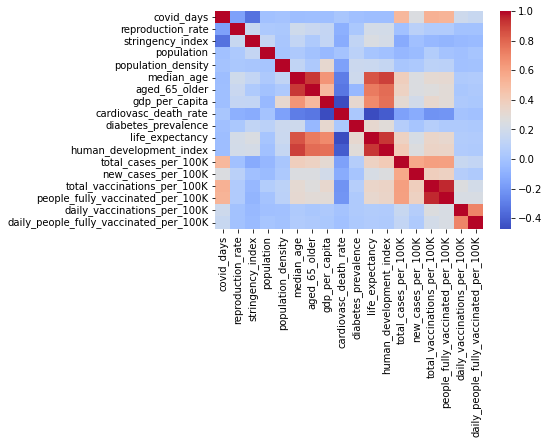

In [42]:
# Visualize the data
plt.figure()
sns.heatmap(phase1_cases_df.corr(), cmap='coolwarm')
plt.show()
# sns.lmplot(x=[x='', y='', data=)
# sns.lmplot(x='', y='', data=)

We should consider dropping one of the following corelated columns: **total_vaccinations_per_100K, people_fully_vaccinated_per_100K**. 

We should consider dropping one of the following corelated columns: **life_expectancy, human_development_index**. 

We should consider dropping one of the following corelated columns: **median_age, aged_65_older**. 

Standardize numerical variables using Scikit-Learn's StandardScaler class. <br>
We must split our data into the training and testing sets prior to standardization to not incorporate the testing values into the scale.

In [43]:
# Remove new cases target from features data
y = phase1_cases_df.new_cases_per_100K
X = phase1_cases_df.drop(["new_cases_per_100K"], axis=1)

In [44]:
X.describe()

,covid_days,reproduction_rate,stringency_index,population,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,total_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
count,99856.000000,99856.000000,99856.000000,9.985600e+04,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000
mean,441.474684,1.008028,54.819652,5.463845e+07,202.876759,30.594998,8.984831,18818.183709,259.332345,7.297077,72.677470,0.724299,3015.599002,24451.818419,9825.939553,2467.820411,738.613575
std,210.038228,0.357605,21.415210,1.760252e+08,711.345766,9.389906,6.497550,19377.210064,121.985397,3.724317,7.687053,0.156740,5337.477175,51685.157853,21449.939494,15999.340326,5888.022715
min,22.000000,-0.030000,0.000000,1.002197e+06,1.980000,15.100000,1.144000,661.240000,79.370000,0.990000,53.280000,0.394000,0.008100,0.000000,0.000000,0.000000,0.000000
25%,261.000000,0.820000,42.130000,5.223376e+06,35.608000,21.500000,3.244000,3689.251000,156.139000,4.820000,66.600000,0.584000,86.101175,0.000000,0.000000,0.000000,0.000000
50%,433.000000,1.000000,55.560000,1.225543e+07,80.080000,29.700000,6.378000,12294.876000,245.465000,6.820000,74.480000,0.750000,519.389600,0.000000,0.000000,0.000000,0.000000
75%,621.000000,1.180000,71.300000,3.983543e+07,145.725000,39.600000,14.799000,27216.445000,329.635000,8.520000,77.970000,0.852000,3883.896600,10410.000000,1980.000000,112.509983,13.257681
max,817.000000,5.820000,100.000000,1.444216e+09,7915.731000,48.200000,27.049000,116935.600000,724.417000,22.020000,84.630000,0.957000,52395.953300,263560.000000,95130.000000,242017.647136,95132.099293


In [46]:
# # Check the balance of our target values
# Counter(y)

In [47]:
# Split the data into training and testing datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [48]:
# Check the shapes of training/ testing datasets.
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (74892, 17)
X_test shape: (24964, 17)
y_train shape: (74892,)
y_test shape: (24964,)


In [ ]:
# X_train = X_train.values.reshape(-1, 1)
# X_test = X_test.values.reshape(-1, 1)

In [49]:
# Create a StandardScaler instance 
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [50]:
# Check the scaled data
X_train_scaled

array([[-0.57105937,  0.36975004, -0.3105722 , ..., -0.45781868,
        -0.15382825, -0.12536871],
       [-0.51874383,  0.00620229,  1.50538332, ..., -0.45781868,
        -0.15382825, -0.12536871],
       [-0.77080959,  0.28585441, -0.00799077, ..., -0.45781868,
        -0.15382825, -0.12536871],
       ...,
       [ 0.05672705,  0.00620229,  0.29459066, ..., -0.45781868,
        -0.15382825, -0.12536871],
       [-0.26667808,  0.17399356,  0.3380167 , ..., -0.45781868,
        -0.15382825, -0.12536871],
       [ 1.69277648, -2.51066674, -1.43497974, ..., -0.45781868,
        -0.15382825, -0.12536871]])

In [51]:
# Create a Random Forest Regression instance and train it
rf_model = RandomForestRegressor(n_estimators=128, random_state=78)

# Train the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [52]:
# Evaluate the model.
y_pred = rf_model.predict(X_test_scaled)

In [53]:
# Create a new DataFrame 
predictions_df = pd.DataFrame({'Actual': y_test, 'Predictions': y_pred})
predictions_df.head()

,Actual,Predictions
id_row,,
55668,54.7092,58.820302
127576,0.0000,0.042723
125221,0.9099,1.107647
36631,36.8305,36.545961
197650,4.9681,9.844170


In [ ]:
# # Scale back the new_cases predictions
# y_new_inverse = scalery.inverse_transform()

In [54]:
# from sklearn.metrics import
rf_model.score(X_train_scaled, y_train)

0.9674106445867541

In [55]:
rf_model.score(X_test_scaled, y_test)

0.7692765935742729

In [57]:
# List the features sorted in descending order by feature importance
feature_importances = rf_model.feature_importances_
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.45804607797328506, 'total_cases_per_100K'),
 (0.13285459524701163, 'covid_days'),
 (0.10189741486185101, 'reproduction_rate'),
 (0.06303733036064786, 'total_vaccinations_per_100K'),
 (0.03593016376138678, 'people_fully_vaccinated_per_100K'),
 (0.027355918908205323, 'daily_vaccinations_per_100K'),
 (0.02711835188899845, 'cardiovasc_death_rate'),
 (0.022219558275157404, 'daily_people_fully_vaccinated_per_100K'),
 (0.02048662468955737, 'gdp_per_capita'),
 (0.018600405455288606, 'life_expectancy'),
 (0.01608990535176647, 'population_density'),
 (0.015381799851719934, 'stringency_index'),
 (0.014487168258740343, 'median_age'),
 (0.014344361967449232, 'diabetes_prevalence'),
 (0.011795679887927388, 'population'),
 (0.011556943647427891, 'aged_65_older'),
 (0.008797699613579232, 'human_development_index')]

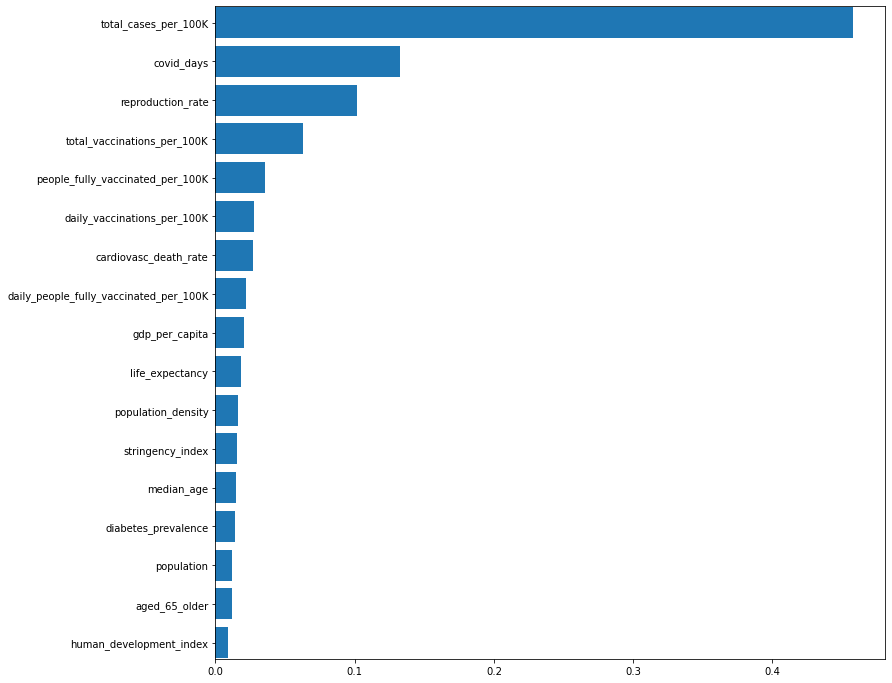

In [58]:
features = sorted(zip(X.columns, rf_model.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(12, 12)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [59]:
# Add a new column "predictions" to the original Dataframe that holds the actual cases. 
cases_predictions = rf_model.predict(X)
phase1_cases_df['predictions'] = cases_predictions
phase1_cases_df.head()

,covid_days,reproduction_rate,stringency_index,population,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K,predictions
id_row,,,,,,,,,,,,,,,,,,,
34,88,1.52,67.59,39835428.0,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.2862,0.0201,0.0,0.0,0.0,0.0,90.076625
35,89,1.52,67.59,39835428.0,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.2862,0.0000,0.0,0.0,0.0,0.0,90.076625
36,90,1.53,67.59,39835428.0,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.4167,0.1305,0.0,0.0,0.0,0.0,89.631458
37,91,1.52,67.59,39835428.0,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.4820,0.0653,0.0,0.0,0.0,0.0,91.425624
38,92,1.52,67.59,39835428.0,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.5899,0.1079,0.0,0.0,0.0,0.0,91.896598
